# Analyzing the Effects of Non-Academic Features on Student Performance

In [299]:
# For reading data sets
import pandas
# For lots of awesome things
import numpy as np
# Need this for LabelEncoder
from sklearn import preprocessing
# For building our net
import keras
# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data

### Data is seperated by a semicolon (delimiter=";") containing column names as the first row of the file (header = 0).

In [300]:
# Read in student data
student_data = np.array(pandas.read_table("./student-por.csv",
delimiter=";", header=0))

# Display student data
student_data

array([['GP', 'F', 18, ..., 0, 11, 11],
       ['GP', 'F', 17, ..., 9, 11, 11],
       ['GP', 'F', 15, ..., 12, 13, 12],
       ...,
       ['MS', 'F', 18, ..., 11, 12, 9],
       ['MS', 'M', 17, ..., 10, 10, 10],
       ['MS', 'M', 18, ..., 10, 11, 11]], dtype=object)

### Determine what the column labels are...

In [301]:
# Descriptions for each feature (found in the header)
feature_descrips = np.array(pandas.read_csv("./student-por.csv",
delimiter=";", header=None, nrows=1))

# Display descriptions
print(feature_descrips)

[['school' 'sex' 'age' 'address' 'famsize' 'Pstatus' 'Medu' 'Fedu' 'Mjob'
  'Fjob' 'reason' 'guardian' 'traveltime' 'studytime' 'failures'
  'schoolsup' 'famsup' 'paid' 'activities' 'nursery' 'higher' 'internet'
  'romantic' 'famrel' 'freetime' 'goout' 'Dalc' 'Walc' 'health'
  'absences' 'G1' 'G2' 'G3']]


### ...and give them clearer descriptions.

In [302]:
# More detailed descriptions
feature_descrips = np.array(["School", "Sex", "Age", "Urban or Rural Address", "Family Size", 
                             "Parent's Cohabitation status", "Mother's Education", "Father's Education",
                             "Mother's Job", "Father's Job", "Reason for Choosing School", 
                             "Student's Gaurdain", "Home to School Travel Time", "Weekly Study Time",
                             "Number of Past Class Failures", "Extra Educational Support", 
                             "Family Educational Support", "Extra Paid Classes", "Extra Curricular Activities",
                             "Attended Nursery School", "Wants to Take Higher Education", "Internet Access at Home", 
                             "In a Romantic Relationship", "Quality of Family Relationships",
                             "Free Time After School", "Time Spent Going out With Friends", 
                             "Workday Alcohol Consumption", "Weekend Alcohol Consumption", 
                             "Current Health Status", "Number of Student Absences", "First Period Grade",
                             "Second Period Grade", "Final Grade"])

# Data Cleanup

## Shuffle data

### We sampled 2 schools, and right now our data has each school grouped together. We need to get rid of this grouping for training later down the road.

In [303]:
# Shuffle the data!
np.random.shuffle(student_data)
student_data

array([['GP', 'F', 16, ..., 14, 14, 15],
       ['GP', 'M', 18, ..., 18, 18, 17],
       ['GP', 'M', 15, ..., 10, 9, 10],
       ...,
       ['GP', 'F', 18, ..., 12, 13, 13],
       ['MS', 'F', 18, ..., 8, 6, 0],
       ['MS', 'F', 17, ..., 8, 8, 0]], dtype=object)

## Alphabetically classify scores

### Because our data is sampled from Portugal, we have to modify their scoring system a bit to represent something more like ours.
### 0 = F
### 1 = D
### 2 = C
### 3 = B
### 4 = A

In [304]:
# Array holding final scores for every student
scores = student_data[:,32]

# Iterate through list of scores, changing them from a 0-19 value
## to a 0-4 value (representing F-A)
for i in range(len(scores)):
    if(scores[i] > 18):
        scores[i] = 4
    elif(scores[i] > 16):
        scores[i] = 3
    elif(scores[i] > 14):
        scores[i] = 2
    elif(scores[i] > 12):
        scores[i] = 1
    else:
        scores[i] = 0
        
# Update the final scores in student_data to reflect these changes
for i in range(len(scores)):
    student_data[i,32] = scores[i]
    
# Display new data. Hint: Look at the last column
student_data

array([['GP', 'F', 16, ..., 14, 14, 2],
       ['GP', 'M', 18, ..., 18, 18, 3],
       ['GP', 'M', 15, ..., 10, 9, 0],
       ...,
       ['GP', 'F', 18, ..., 12, 13, 1],
       ['MS', 'F', 18, ..., 8, 6, 0],
       ['MS', 'F', 17, ..., 8, 8, 0]], dtype=object)

## Encoding non-numeric data to integers

In [305]:
# One student sample
student_data[0,:]

array(['GP', 'F', 16, 'U', 'GT3', 'T', 4, 3, 'health', 'other', 'home',
       'mother', 1, 2, 0, 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
       'no', 4, 3, 5, 1, 5, 2, 2, 14, 14, 2], dtype=object)

### We have some qualitative data from the questionaire that needs to be converted to represent numbers.

In [306]:
# Label Encoder
le = preprocessing.LabelEncoder()

# Columns that hold non-numeric data
indices = np.array([0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])

# Transform the non-numeric data in these columns to integers
for i in range(len(indices)):
    column = indices[i]
    le.fit(student_data[:,column])
    student_data[:,column] = le.transform(student_data[:,column])

In [307]:
student_data[0,:]

array([0, 0, 16, 1, 0, 1, 4, 3, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 4, 3, 5, 1, 5, 2, 2, 14, 14, 2], dtype=object)

## Encoding 0's to -1 for binomial data.

### We want our weights to change because 0 represents something! Therefore, we need to encode 0's to -1's so the weights will change with that input.

In [308]:
# Columns that hold binomial data
indices = np.array([0,1,3,4,5,15,16,17,18,19,20,21,22])

# Change 0's to -1's
for i in range(len(indices)):
    column = indices[i]
    
    # values of current feature
    feature = student_data[:,column]
    
    # change values to -1 if equal to 0
    feature = np.where(feature==0, -1, feature)
    student_data[:,column] = feature
    
student_data[0,:]

array([-1, -1, 16, 1, -1, 1, 4, 3, 1, 2, 1, 1, 1, 2, 0, -1, 1, -1, 1, 1,
       1, 1, -1, 4, 3, 5, 1, 5, 2, 2, 14, 14, 2], dtype=object)

## Standardizing the nominal and numerical data.

### We need our input to matter equally (Everyone is important!). We do this by standardizing our data (get a mean of 0 and a stardard deviation of 1).

In [309]:
scaler = preprocessing.StandardScaler()

In [310]:
temp = student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]]
print(student_data[0,:])
Standardized = scaler.fit_transform(temp)

[-1 -1 16 1 -1 1 4 3 1 2 1 1 1 2 0 -1 1 -1 1 1 1 1 -1 4 3 5 1 5 2 2 14 14
 2]


/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [311]:
print('Mean:', round(Standardized.mean()))
print('Standard deviation:', Standardized.std())

Mean: -0.0
Standard deviation: 1.0


In [312]:
student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]] = Standardized

In [313]:
student_data[0,:]

array([-1, -1, -0.6114217963383591, 1, -1, 1, 1.310215632680141,
       0.6308661935384804, -0.7547559518087241, -0.2607275884816344,
       -0.09443227937322239, 0.3326475069742608, -0.7600319244561619,
       0.08365294968062233, -0.3743051181921297, -1, 1, -1, 1, 1, 1, 1,
       -1, 0.07260614867809903, -0.17164653548813819, 1.5449502524562555,
       -0.5435553304269218, 2.1190506314700777, -1.0630145705792504,
       -0.3578630461124801, 0.9481527247699899, 0.8346149320213242, 2],
      dtype=object)

## Convert results to one-hot encoding

In [314]:
# Final grades
results = student_data[:,32]

# Take a look at first 5 final grades
print("First 5 final grades:", results[0:5])

# All unique values for final grades (0-4 representing F-A)
possible_results = np.unique(student_data[:,32]).T
print("All possible results:", possible_results)

First 5 final grades: [2 3 0 1 1]
All possible results: [0 1 2 3 4]


In [315]:
# One-hot encode final grades (results) which will be used as our output
# The length of the "ID" should be as long as the total number of possible results so each results
## gets its own, personal one-hot encoding
y = keras.utils.to_categorical(results,len(possible_results))

# Take a look at the first 5 final grades now (no longer numbers but arrays)
y[0:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [316]:
# our input, all features except final grades
x = student_data[:,0:32]

# Model Building

#### Now let's create a function that will build a model for us. This will come in handy later on. Our model will have two hidden layers. The first hidden layer will have an input size of 800, and the second will have an input size of 400. The optimizer that we are using is adamax which is good at ignoring noise in a datset. The loss function we are using is called categorical cross entropy and which is useful for trying to classify or label something. In this case, we are trying to classify students by letter grades, so this loss function will be of great use to us.

In [317]:
# Function to create network given model
def create_network(model):
    # Specify input/output size
    input_size = x.shape[1]
    output_size = y.shape[1]

    # Create the hidden layer
    model.add(keras.layers.Dense(800, input_dim = input_size, activation = 'relu'))

    # Additional hidden layer
    model.add(keras.layers.Dense(400,activation='relu'))

    # Output layer
    model.add(keras.layers.Dense(output_size,activation='softmax'))

    # Compile - why using adamax?
    model.compile(loss='categorical_crossentropy',
                  optimizer='adamax', 
                  metrics=['accuracy'])

In [318]:
# Feed-forward model
model = keras.Sequential()
create_network(model)

# Initial Test of the Network

In [319]:
# Split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

y_train = y[0:518,:]
y_test = y[519:649,:]

In [320]:
# Train on training data! 
# We're saving this information in the variable -history- so we can take a look at it later
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [321]:
# Validate using data the network hasn't seen before (testing data)
# Save this info in -score- so we can take a look at it
score = model.evaluate(x_test,y_test, verbose=0)

# Check it's effectiveness
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.49870656898173576
Test accuracy: 0.7692307692307693


In [322]:
# Plot the data
def plot(history):

    plt.figure(1)

    # Summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc ='upper left')

    # Summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc ='upper left')

    # Display plot
    
    plt.tight_layout()
    plt.show()

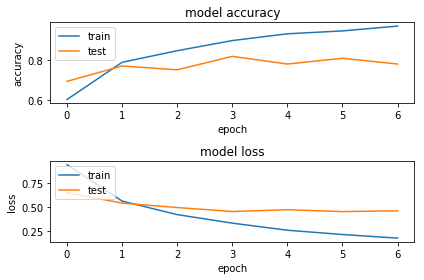

In [323]:
# Plot current training and validation accuracy and loss
plot(history)

# Training and Testing Without Individual Features

In [324]:
# Analyze the effects of removing one feature on training
def remove_and_analyze(feature):
    # Told you those feature descriptions would be useful
    print("Without feature", feature, ":", feature_descrips[feature])
    
    # Create feed-forward network
    model = keras.Sequential()
    create_network(model)
    
    # Remove feature from columns (axis 1)
    x = np.delete(student_data, feature, axis = 1)
    
    # Split data into training and testing data
    x_train = x[0:518,:]
    x_test = x[519:649,:]
    
    # Train on training data!
    history = model.fit(x_train, y_train,
                        batch_size = 32, 
                        epochs = 7, 
                        verbose = 0, 
                        validation_split = 0.2)
    
    # Validate using data the network hasn't seen before (testing data)
    score = model.evaluate(x_test,y_test, verbose=0)
    
    # Check it's effectiveness
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # Plot the data
    plot(history)

Without feature 0 : School
Test loss: 0.1621086014179477
Test accuracy: 0.9461538461538461


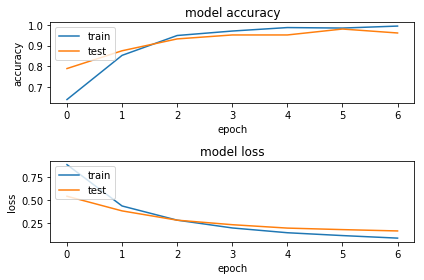


 
 

Without feature 1 : Sex
Test loss: 0.18013948816973985
Test accuracy: 0.9230769230769231


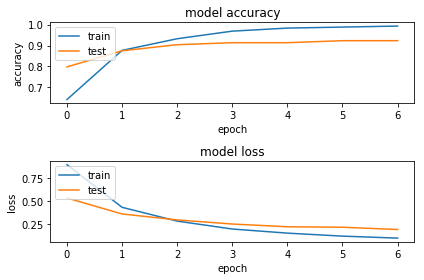


 
 

Without feature 2 : Age
Test loss: 0.1791339682258415
Test accuracy: 0.9461538461538461


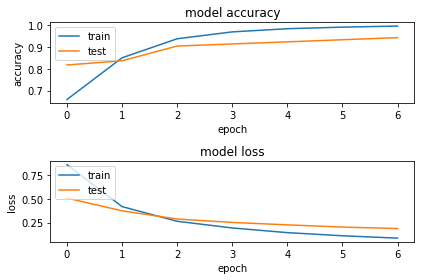


 
 

Without feature 3 : Urban or Rural Address
Test loss: 0.14879764584475197
Test accuracy: 0.9461538461538461


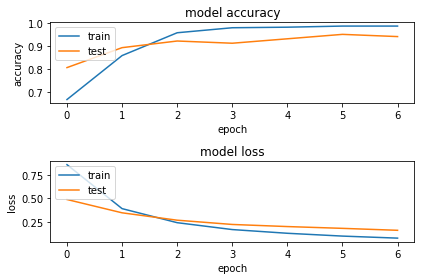


 
 

Without feature 4 : Family Size
Test loss: 0.18590232501961648
Test accuracy: 0.9153846153846154


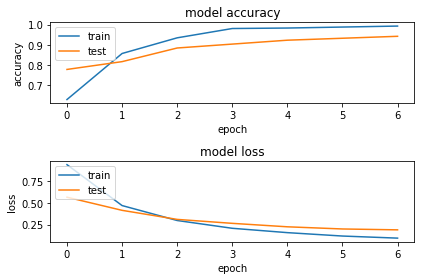


 
 

Without feature 5 : Parent's Cohabitation status
Test loss: 0.14618542127293319
Test accuracy: 0.9538461538461539


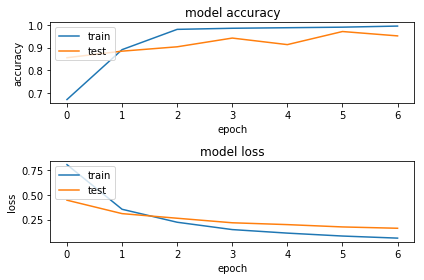


 
 

Without feature 6 : Mother's Education
Test loss: 0.17238728130844092
Test accuracy: 0.9384615384615385


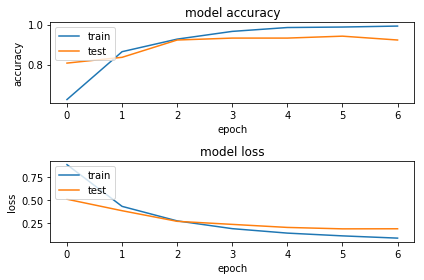


 
 

Without feature 7 : Father's Education
Test loss: 0.18062142854771362
Test accuracy: 0.9384615384615385


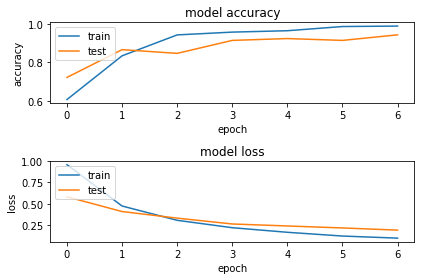


 
 

Without feature 8 : Mother's Job
Test loss: 0.1844687131576043
Test accuracy: 0.9384615384615385


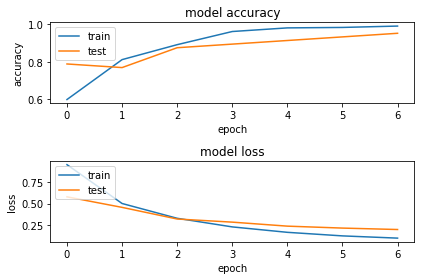


 
 

Without feature 9 : Father's Job
Test loss: 0.19276156531414018
Test accuracy: 0.9384615384615385


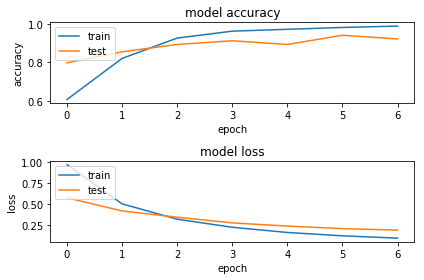


 
 

Without feature 10 : Reason for Choosing School
Test loss: 0.18237095216105584
Test accuracy: 0.9538461538461539


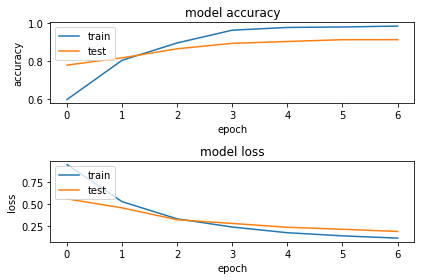


 
 

Without feature 11 : Student's Gaurdain
Test loss: 0.163004635179487
Test accuracy: 0.9615384615384616


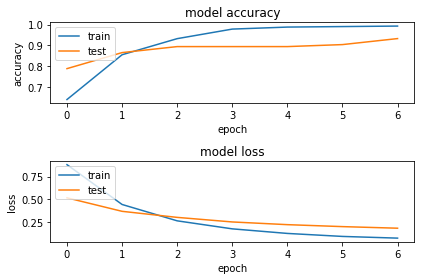


 
 

Without feature 12 : Home to School Travel Time
Test loss: 0.17869377290850164
Test accuracy: 0.9230769230769231


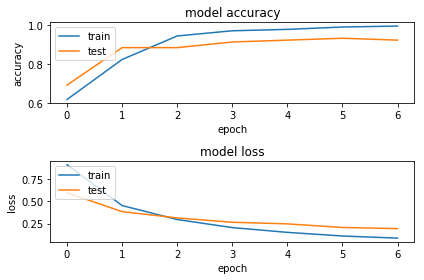


 
 

Without feature 13 : Weekly Study Time
Test loss: 0.17055197102275158
Test accuracy: 0.9692307692307692


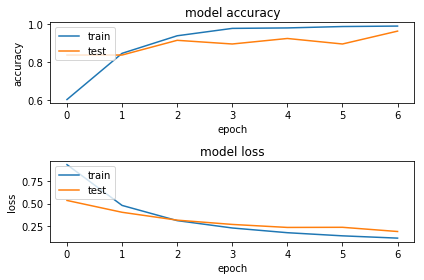


 
 

Without feature 14 : Number of Past Class Failures
Test loss: 0.20900033993821127
Test accuracy: 0.9153846153846154


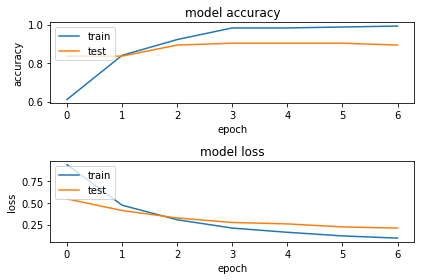


 
 

Without feature 15 : Extra Educational Support
Test loss: 0.21641568702314265
Test accuracy: 0.9230769230769231


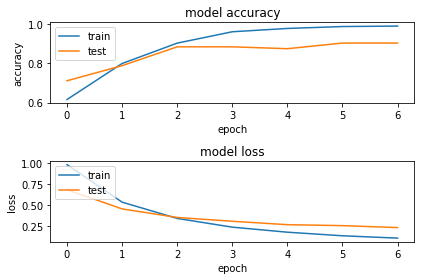


 
 

Without feature 16 : Family Educational Support
Test loss: 0.18597653391771019
Test accuracy: 0.9230769230769231


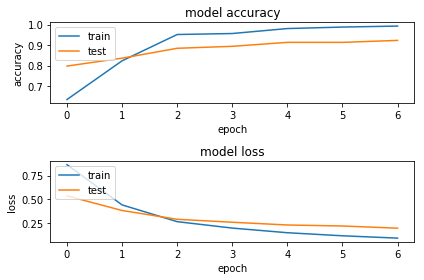


 
 

Without feature 17 : Extra Paid Classes
Test loss: 0.17740342028118902
Test accuracy: 0.9307692307692308


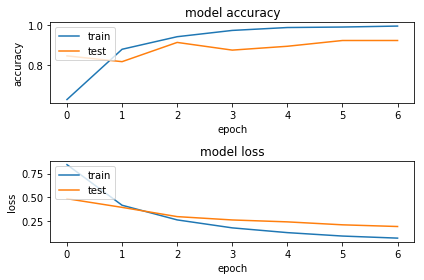


 
 

Without feature 18 : Extra Curricular Activities
Test loss: 0.20625294881689255
Test accuracy: 0.9307692307692308


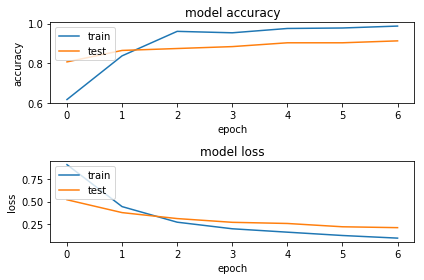


 
 

Without feature 19 : Attended Nursery School
Test loss: 0.19645364175555116
Test accuracy: 0.9153846153846154


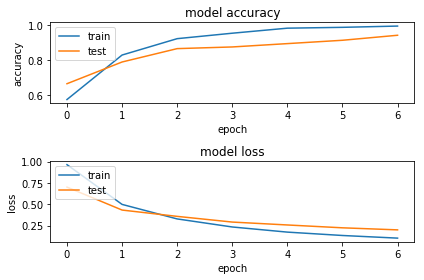


 
 

Without feature 20 : Wants to Take Higher Education
Test loss: 0.19295341709355573
Test accuracy: 0.9153846153846154


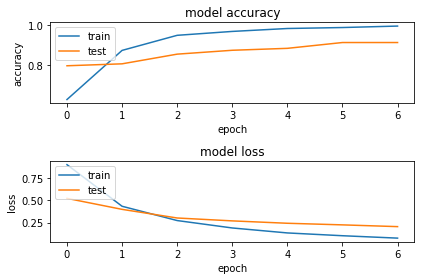


 
 

Without feature 21 : Internet Access at Home
Test loss: 0.21023256348293776
Test accuracy: 0.8846153846153846


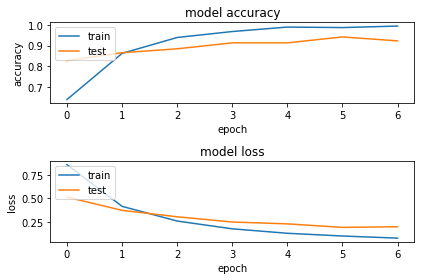


 
 

Without feature 22 : In a Romantic Relationship
Test loss: 0.18865548782990887
Test accuracy: 0.9307692307692308


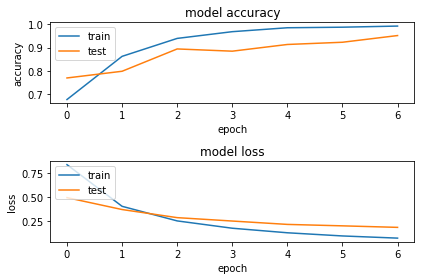


 
 

Without feature 23 : Quality of Family Relationships
Test loss: 0.1689123633814653
Test accuracy: 0.9384615384615385


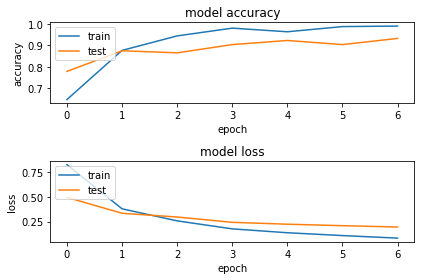


 
 

Without feature 24 : Free Time After School
Test loss: 0.18237824091047514
Test accuracy: 0.9230769230769231


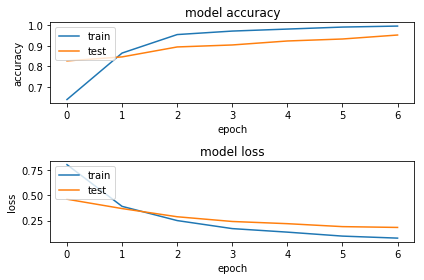


 
 

Without feature 25 : Time Spent Going out With Friends
Test loss: 0.17455922076254726
Test accuracy: 0.9307692307692308


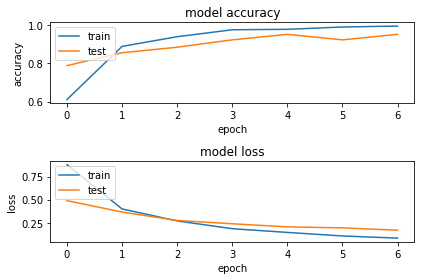


 
 

Without feature 26 : Workday Alcohol Consumption
Test loss: 0.1658898144242882
Test accuracy: 0.9461538461538461


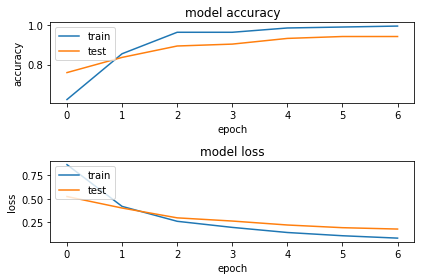


 
 

Without feature 27 : Weekend Alcohol Consumption
Test loss: 0.1997596699001196
Test accuracy: 0.9076923076923077


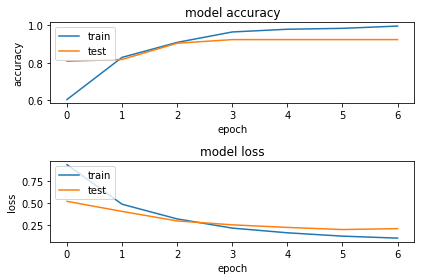


 
 

Without feature 28 : Current Health Status
Test loss: 0.18893475666745171
Test accuracy: 0.9384615384615385


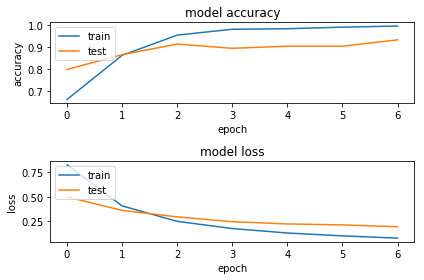


 
 

Without feature 29 : Number of Student Absences
Test loss: 0.18861065465199106
Test accuracy: 0.9384615384615385


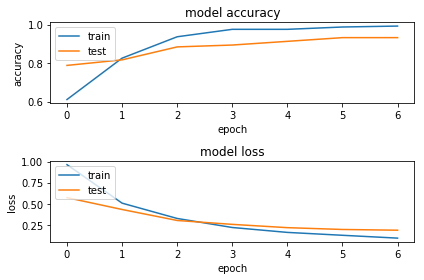


 
 

Without feature 30 : First Period Grade
Test loss: 0.19695381799784417
Test accuracy: 0.9538461538461539


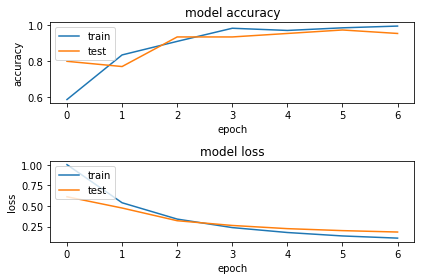


 
 

Without feature 31 : Second Period Grade
Test loss: 0.21027804316702084
Test accuracy: 0.9230769230769231


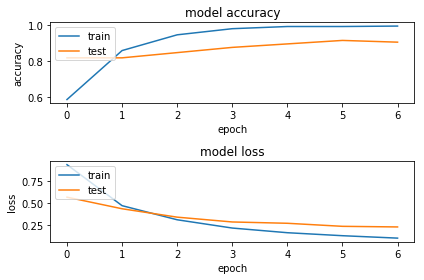

In [325]:
# Analyze the effects of removing one feature on training
# Do this for all input features
for i in range(student_data.shape[1]-1):
    remove_and_analyze(i)
    print("\n \n \n")

# Training and Testing Without Five Features

Test loss: 0.1731401116976765
Test accuracy: 0.9307692307692308


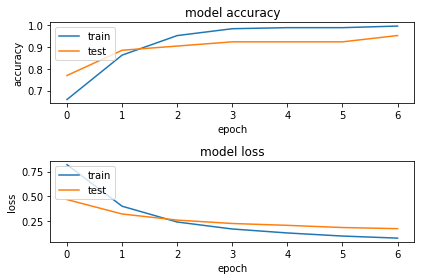

In [326]:
# Delete the five features that most negatively impact accuracy
x = np.delete(student_data, 21, axis = 1)
x = np.delete(x, 20, axis = 1)
x = np.delete(x, 9, axis = 1)
x = np.delete(x, 8, axis = 1)
x = np.delete(x, 7, axis = 1)

# Create feed-forward network
model = keras.Sequential()
create_network(model)

# Split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

# Train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

# Validate using data the network hasn't seen before (testing data)
score = model.evaluate(x_test,y_test, verbose=0)

# Check it's effectiveness
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot the data
plot(history)

# Grade Distribution Analysis

In [327]:
# Function for analyzing the percent of students with each grade [F,D,C,B,A]
def analyze(array):
    
    # To hold the total number of students with a certain final grade
    # Index 0 - F. Index 4 - A
    sums = np.array([0,0,0,0,0])
    
    # Iterate through array. Update sums according to whether a student got a final grade of a(n)
    for i in range(len(array)):
        # F
        if(array[i]==0):
            sums[0] += 1
        # D
        elif(array[i]==1):
            sums[1] +=1
        # C
        elif(array[i]==2):
            sums[2] +=1
        # B
        elif(array[i]==3):
            sums[3] +=1
        # A
        else:
            sums[4] += 1
            
    # Total number of students
    total = sums[0] + sums[1] + sums[2] + sums[3] + sums[4]
    
    # Hold percentage of students with grade of [F,D,C,B,A]
    percentages = np.array([sums[0]/total*100, 
                            sums[1]/total*100, 
                            sums[2]/total*100, 
                            sums[3]/total*100, 
                            sums[4]/total*100])
    
    # One bar for each of the 5 grades
    x = np.array([1,2,3,4,5])
    
    # Descriptions for each bar. None on y-axis
    plt.xticks(np.arange(6), ('', 'F', 'D', 'C', 'B','A'))
    
    # X axis - grades. Y axis - percentage of students with each grade
    plt.bar(x,percentages)
    plt.xlabel("Grades")
    plt.ylabel("Percentage of Students")
    
    # Display bar graph
    plt.show()
    
    # Display percentages
    print(percentages)

## Family Educational Support

In [328]:
# Array holding final grades of all students who have family educational support
fam_sup = []
# Array holding final grades of all students who have family educational support
no_fam_sup = []

# Iterate through all student samples
for i in range(student_data.shape[0]):
    
    # Does the student have family educational support? (-1 no, 1 yes)
    sup = student_data[i][16]
    
    # Append student's final grade to corresponding array
    if(sup==1):
        fam_sup.append(student_data[i][32])
    else:
        no_fam_sup.append(student_data[i][32])

### Family Educational Support

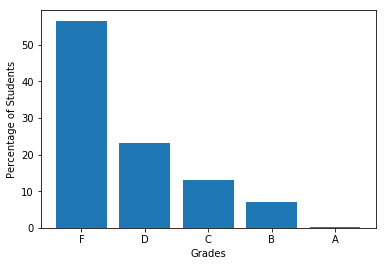

[56.53266332 23.11557789 13.06532663  7.03517588  0.25125628]


In [329]:
analyze(fam_sup)

### No Family Educational Support

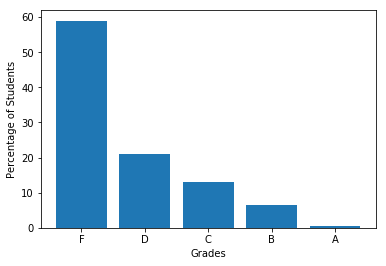

[58.96414343 21.11553785 13.14741036  6.37450199  0.39840637]


In [330]:
analyze(no_fam_sup)

## Reason for choosing school

In [331]:
# Each array holds the grades of students who chose to go to their school for that reason
# Close to home
reason1 = []
# School reputation
reason2 = []
# Course prefrence
reason3 = []
# Other
reason4 = []

# Values that represent these unique reasons. They are not integer numbers like in the previous
## example. They're floatig point numbers so we'll save them so we can compare them to the value
## of this feature in each sample
unique_reasons = np.unique(student_data[:,10])

# Iterate through all student samples and append final grades to corresponding arrays 
for i in range(student_data.shape[0]):
    
    reason = student_data[i][10]
   
    if(reason==unique_reasons[0]):
        reason1.append(student_data[i][32])
    elif(reason==unique_reasons[1]):
        reason2.append(student_data[i][32])
    elif(reason==unique_reasons[2]):
        reason3.append(student_data[i][32])
    else:
        reason4.append(student_data[i][32])

### Reason 1: Close to Home

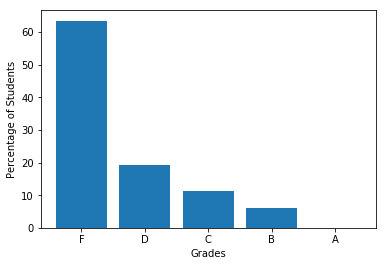

[63.50877193 19.29824561 11.22807018  5.96491228  0.        ]


In [332]:
analyze(reason1)

### Reason 2: School Reputation

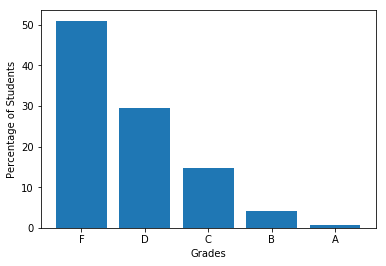

[51.00671141 29.53020134 14.76510067  4.02684564  0.67114094]


In [333]:
analyze(reason2)

### Reason 3: Course Prefrence

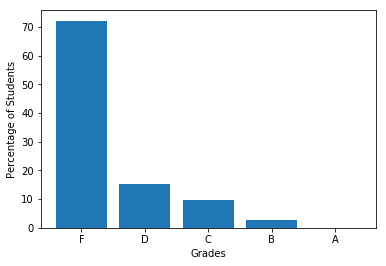

[72.22222222 15.27777778  9.72222222  2.77777778  0.        ]


In [334]:
analyze(reason3)

### Reason 4: Other

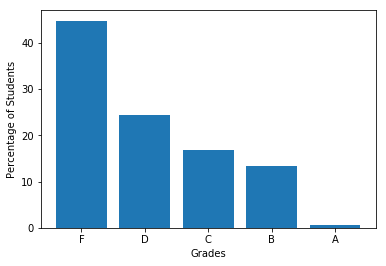

[44.75524476 24.47552448 16.78321678 13.28671329  0.6993007 ]


In [335]:
analyze(reason4)

## Frequency of Going Out With Friends

In [336]:
# Each array holds the grades of students who go out with friends for that specified amount of time 
# (1 - very low, 5 - very high)
go_out1 = []
go_out2 = []
go_out3 = []
go_out4 = []
go_out5 = []

# Floating point values representing frequency
unique = np.unique(student_data[:,25])

# Iterate through all student samples and append final grades to corresponding arrays 
for i in range(student_data.shape[0]):
    
    frequency = student_data[i][25]
    
    if(frequency==unique[0]):
        go_out1.append(student_data[i][32])
    elif(frequency==unique[1]):
        go_out2.append(student_data[i][32])
    elif(frequency==unique[2]):
        go_out3.append(student_data[i][32])
    elif(frequency==unique[3]):
        go_out4.append(student_data[i][32])
    else:
        go_out5.append(student_data[i][32])

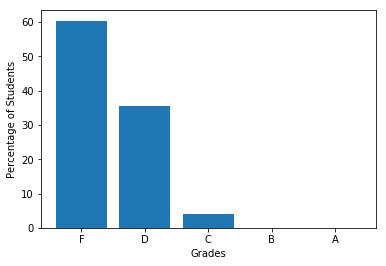

[60.41666667 35.41666667  4.16666667  0.          0.        ]


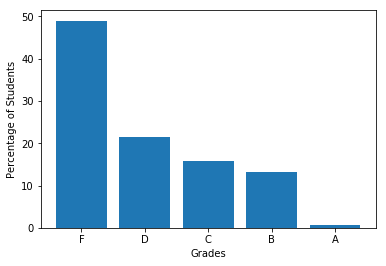

[48.96551724 21.37931034 15.86206897 13.10344828  0.68965517]


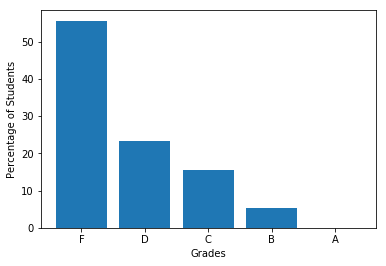

[55.6097561  23.41463415 15.6097561   5.36585366  0.        ]


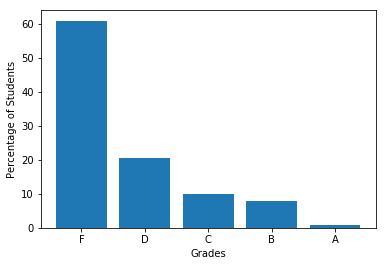

[60.9929078  20.56737589  9.92907801  7.80141844  0.70921986]


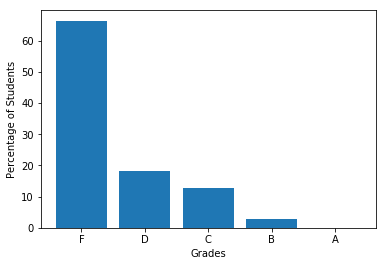

[66.36363636 18.18181818 12.72727273  2.72727273  0.        ]


In [337]:
analyze(go_out1)
analyze(go_out2)
analyze(go_out3)
analyze(go_out4)
analyze(go_out5)

## Free Time after School

In [338]:
# Each array holds the grades of students who have the specified amount of free time after school 
# (1 - very low, 5 - very high)
free1 = []
free2 = []
free3 = []
free4 = []
free5 = []

# Floating point values representing frequency
unique = np.unique(student_data[:,24])

# Iterate through all student samples and append final grades to corresponding arrays 
for i in range(student_data.shape[0]):
   
    frequency = student_data[i][24]
    
    if(frequency==unique[0]):
        free1.append(student_data[i][32])
    elif(frequency==unique[1]):
        free2.append(student_data[i][32])
    elif(frequency==unique[2]):
        free3.append(student_data[i][32])
    elif(frequency==unique[3]):
        free4.append(student_data[i][32])
    else:
        free5.append(student_data[i][32])

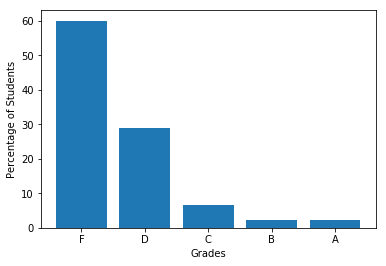

[60.         28.88888889  6.66666667  2.22222222  2.22222222]


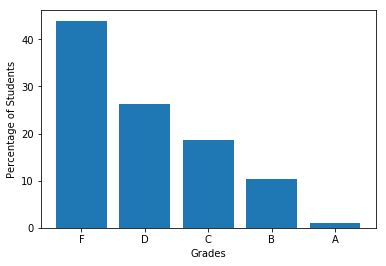

[43.92523364 26.1682243  18.69158879 10.28037383  0.93457944]


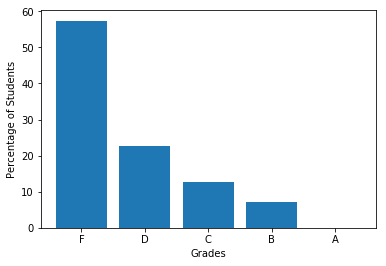

[57.37051793 22.70916335 12.74900398  7.17131474  0.        ]


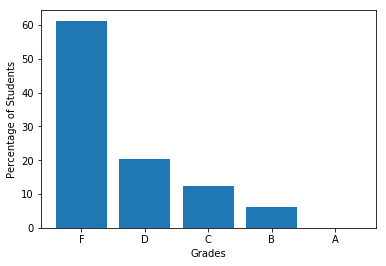

[61.23595506 20.2247191  12.35955056  6.17977528  0.        ]


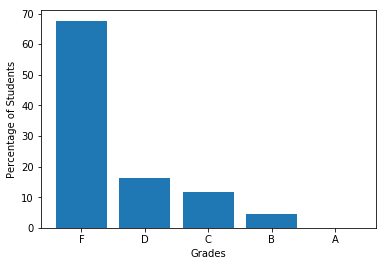

[67.64705882 16.17647059 11.76470588  4.41176471  0.        ]


In [339]:
analyze(free1)
analyze(free2)
analyze(free3)
analyze(free4)
analyze(free5)

## Paid Classes

In [340]:
# Array holding final grades of all students who have extra paid classes
paid_class = []
# Array holding final grades of all students who do not have extra paid classes
no_paid_class = []

# Iterate through all student samples and append final grades to corresponding arrays 
for i in range(student_data.shape[0]):
    
    paid = student_data[i][17]
    
    if(paid==1):
        paid_class.append(student_data[i][32])
    else:
        no_paid_class.append(student_data[i][32])

### Extra Paid Classes

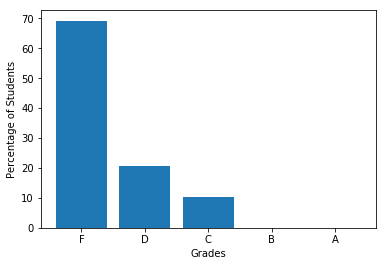

[69.23076923 20.51282051 10.25641026  0.          0.        ]


In [341]:
analyze(paid_class)

### No Extra Paid Classes

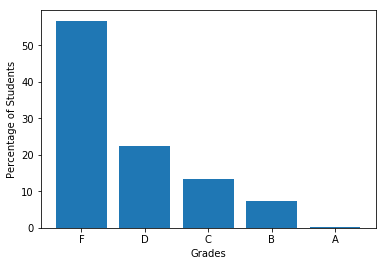

[56.72131148 22.45901639 13.27868852  7.21311475  0.32786885]


In [342]:
analyze(no_paid_class)